In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

In [2]:
import importlib

import endoutbreakvbd
import endoutbreakvbd.chikungunya
import endoutbreakvbd.eop
import endoutbreakvbd.model
import endoutbreakvbd.utils

importlib.reload(endoutbreakvbd.model)
importlib.reload(endoutbreakvbd.eop)
importlib.reload(endoutbreakvbd.chikungunya)
importlib.reload(endoutbreakvbd.utils)
importlib.reload(endoutbreakvbd)

from endoutbreakvbd import eop_analytical, eop_simulation, renewal_model
from endoutbreakvbd.chikungunya import get_parameters, get_weather_data
from endoutbreakvbd.utils import month_start_xticks

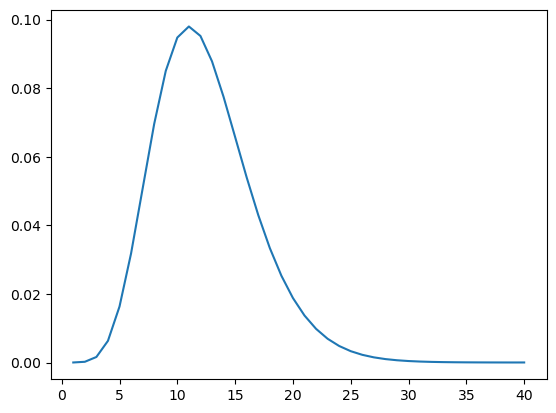

In [3]:
parameters = get_parameters()
gen_time_dist_vec = parameters["gen_time_dist_vec"]
rng = np.random.default_rng(2)

plt.plot(range(1, len(gen_time_dist_vec) + 1), gen_time_dist_vec)

In [8]:
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.deterministic import DeterministicProcess, Fourier

df_weather = get_weather_data()
dp = DeterministicProcess(
    index=df_weather.index,
    constant=True,
    additional_terms=[Fourier(order=2, period=365)],
    drop=True,
)
X = dp.in_sample()  # DataFrame with sin/cos columns + intercept
y = df_weather["temperature"].loc[X.index]
model = OLS(y, X).fit()
df_weather_smoothed = pd.DataFrame(
    {"doy": X.index.dayofyear, "temperature": model.fittedvalues},
    index=X.index,
)
doy_all = df_weather_smoothed.index.dayofyear.values
temperature_smoothed_all = df_weather_smoothed["temperature"].values

temperature_grid = np.linspace(10, 40, 61)
suitability_grid = np.array(
    [
        0.00000000e00,
        0.00000000e00,
        1.88203984e-08,
        1.28367618e-07,
        5.36961844e-07,
        2.82007101e-06,
        1.28234033e-05,
        5.25931083e-05,
        1.82882567e-04,
        5.50222548e-04,
        1.48801416e-03,
        3.62102778e-03,
        7.92083800e-03,
        1.57431781e-02,
        2.88100329e-02,
        4.86355377e-02,
        7.66192219e-02,
        1.13479057e-01,
        1.59883423e-01,
        2.15867501e-01,
        2.80759580e-01,
        3.53556862e-01,
        4.32786966e-01,
        5.16530769e-01,
        6.02553457e-01,
        6.88071907e-01,
        7.69834160e-01,
        8.44406132e-01,
        9.08117700e-01,
        9.57439287e-01,
        9.89023789e-01,
        1.00000000e00,
        9.88217659e-01,
        9.52537702e-01,
        8.92959231e-01,
        8.10907665e-01,
        7.09457680e-01,
        5.93673840e-01,
        4.69879650e-01,
        3.45600684e-01,
        2.29671637e-01,
        1.32825400e-01,
        6.50191949e-02,
        2.73829517e-02,
        1.02714042e-02,
        3.48809148e-03,
        1.03983518e-03,
        3.27940090e-04,
        7.74962840e-05,
        1.17503236e-05,
        0.00000000e00,
        0.00000000e00,
        0.00000000e00,
        0.00000000e00,
        0.00000000e00,
        0.00000000e00,
        0.00000000e00,
        0.00000000e00,
        0.00000000e00,
        0.00000000e00,
        0.00000000e00,
    ]
)

suitability_all = np.interp(
    temperature_smoothed_all, temperature_grid, suitability_grid, period=365
)

rep_no_max = 2.5
rep_no_all = rep_no_max * suitability_all


def rep_no_func_doy(doy):
    return np.interp(doy, doy_all, rep_no_all, period=365)

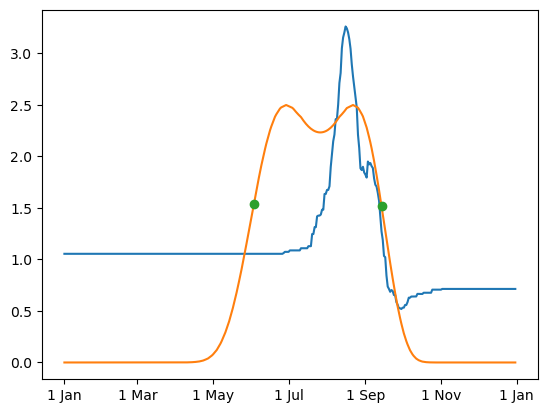

In [12]:
# # rep_no_max = 2.5
# # rep_no_min = -2
# # doy_max = parameters["rep_no_func_doy"](np.arange(1, 366)).argmax() + 1
# rep_no_max = 1.4
# rep_no_min = -1
# doy_max = 215


# def rep_no_func_doy(doy):
#     return np.maximum(
#         0.5
#         * (
#             rep_no_max
#             + rep_no_min
#             + (rep_no_max - rep_no_min) * np.cos(2 * np.pi * (doy - doy_max) / 365)
#         ),
#         0,
#     )

# doy_max = 208


# def rep_no_func_doy(doy):
#     c_0 = -9
#     c_1 = 0.3
#     rep_no_max = 7.5
#     temperature = (
#         16.3688
#         - 2.5601 * np.sin(2 * np.pi * (doy - 1) / 365)
#         - 9.0883 * np.cos(2 * np.pi * (doy - 1) / 365)
#         + 1.3871 * np.sin(4 * np.pi * (doy - 1) / 365)
#         + 0.3780 * np.cos(4 * np.pi * (doy - 1) / 365)
#     )
#     rep_no = rep_no_max / (1 + np.exp(-(c_0 + c_1 * temperature)))
#     return rep_no

example_doys = [
    (rep_no_all > 1.5).nonzero()[0][0] + 1,
    (rep_no_all > 1.5).nonzero()[0][-1] + 1,
]

fig, ax = plt.subplots()
doy_vec = np.arange(1, 366)
ax.plot(doy_vec, parameters["rep_no_func_doy"](doy_vec))
ax.plot(doy_vec, rep_no_func_doy(doy_vec))
ax.plot(example_doys, rep_no_func_doy(np.array(example_doys)), "o")
month_start_xticks(ax)

100%|██████████| 100/100 [00:00<00:00, 1055.40it/s]


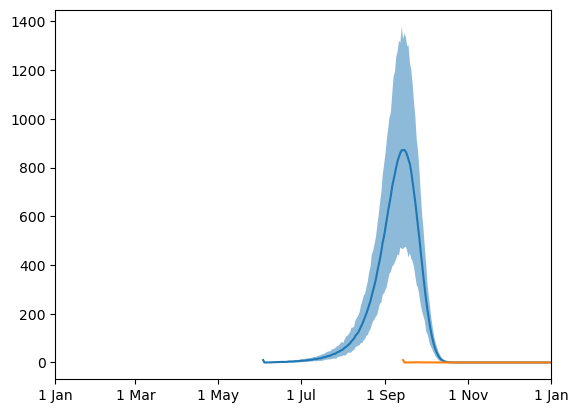

In [13]:
no_sims = 100
fig, ax = plt.subplots()
for doy_start in example_doys:
    incidence_mat = np.zeros((no_sims, 366), dtype=int)
    for sim_idx in tqdm(range(no_sims)):
        incidence_vec = renewal_model(
            rep_no_func=lambda t: rep_no_func_doy(doy_start + t),
            t_stop=366,
            gen_time_dist_vec=gen_time_dist_vec,
            rng=rng,
            incidence_init=10,
        )
        incidence_mat[sim_idx, : len(incidence_vec)] = incidence_vec
    incidence_mean = incidence_mat.mean(axis=0)
    incidence_lower = np.percentile(incidence_mat, 2.5, axis=0)
    incidence_upper = np.percentile(incidence_mat, 97.5, axis=0)
    doy_vec = np.arange(doy_start, doy_start + len(incidence_mean))
    ax.plot(doy_vec, incidence_mean)
    ax.fill_between(
        doy_vec,
        incidence_lower,
        incidence_upper,
        alpha=0.5,
    )
    ax.set_xlim(1, 366)
    month_start_xticks(ax)

100%|██████████| 56/56 [00:17<00:00,  3.11it/s]


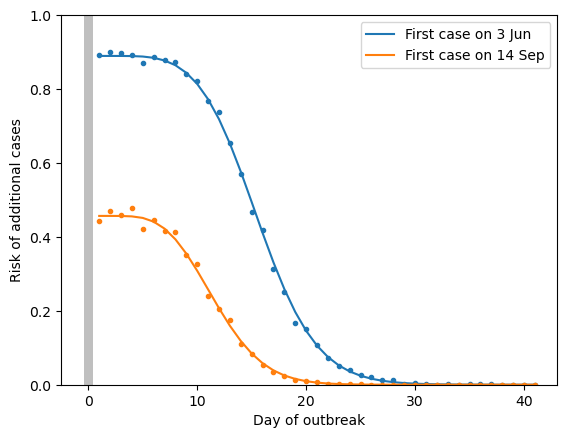

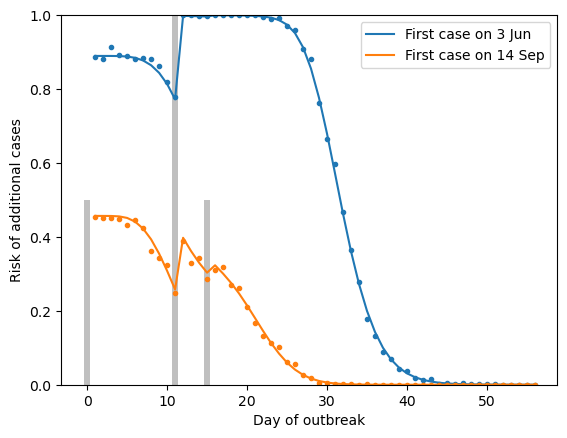

In [14]:
for incidence_vec in [[1], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1]]:
    fig, ax = plt.subplots()
    ax.bar(
        np.arange(len(incidence_vec)),
        incidence_vec / np.max(incidence_vec),
        color="gray",
        alpha=0.5,
    )
    for doy_start, color in zip(
        example_doys,
        ["tab:blue", "tab:orange"],
        strict=True,
    ):
        date_start = pd.Timestamp(year=2017, month=1, day=1) + pd.Timedelta(
            days=doy_start - 1
        )
        eop_days = np.arange(1, len(incidence_vec) + len(gen_time_dist_vec) + 1)
        eop_vals = eop_analytical(
            incidence_vec=incidence_vec,
            rep_no_func=lambda t: rep_no_func_doy(doy_start + t),
            gen_time_dist_vec=gen_time_dist_vec,
            t_calc=eop_days,
        )
        ax.plot(
            eop_days,
            1 - eop_vals,
            label=f"First case on {date_start.day} {date_start:%b}",
            color=color,
        )
        eop_days_sim = np.arange(1, len(incidence_vec) + len(gen_time_dist_vec) + 1)
        eop_vals_sim = eop_simulation(
            incidence_vec=incidence_vec,
            rep_no_func=lambda t: rep_no_func_doy(doy_start + t),
            gen_time_dist_vec=gen_time_dist_vec,
            t_calc=eop_days_sim,
            n_sims=1000,
            rng=rng,
        )
        ax.plot(eop_days_sim, 1 - eop_vals_sim, ".", color=color)
        ax.set_ylim(0, 1)
        ax.set_xlabel("Day of outbreak")
        ax.set_ylabel("Risk of additional cases")
        ax.legend()